## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [1]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

ImportError: bad magic number in 'get_data': b'\x03\xf3\r\n'

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [2]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
from scipy import ndimage
from scipy.misc import imresize
from skimage.transform import resize

import re
import glob
import numpy as np
def load_imgs_and_keypoints(dirname='data'):
    # Write your code for loading images and points here
    df=pd.read_csv(dirname+'/gt.csv', sep=',',header=None)

     
    col_dir = dirname+'/images/*.jpg'
    print(col_dir)
    faces = np.zeros((6000,100,100,3))

    points = df.values[1:][:,1:].astype(float)
    
    for i, face in enumerate(glob.glob(col_dir)):
        image =  ndimage.imread(face)
        faces[i] = resize(image, (100,100,3))
        w = image.shape[1]
        h = image.shape[0]
        points[i,:] = points[i,:]/np.array([w,h]*14) - 0.5
    return faces, points


imgs, points= load_imgs_and_keypoints()

data/images/*.jpg


C:\Users\Kiko-PC\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
C:\Users\Kiko-PC\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Kiko-PC\Anaconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

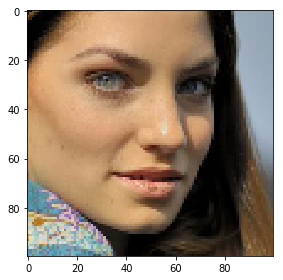

In [2]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

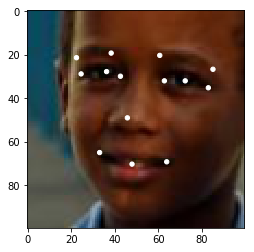

In [3]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def convert_point(coordinate):
    return (coordinate+0.5)*100

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    for x, y in zip(points[0::2], points[1::2]):
        c = Circle((convert_point(x), convert_point(y)), radius=1, color="white")
        ax.add_patch(c)
        
    plt.imshow(img)
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [4]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

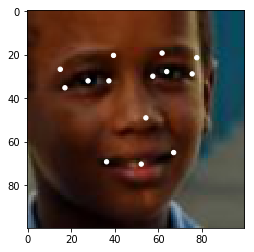

In [5]:
def flip_img(img, points):
    # Write your code for flipping here
    points = np.copy(points)
    points[0::2]*=(-1)
    return np.flip(img, axis=1), points
    

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [6]:
from skimage.transform import resize

img_len = len(points_train)
aug_imgs_train = np.zeros((2*img_len, *imgs_train[0].shape))
aug_points_train = np.zeros((2*img_len, *points_train[0].shape))

for i in range(img_len): 

    flipped_image, flipped_points = flip_img(imgs_train[i], points_train[i])
    aug_imgs_train[i] = imgs_train[i]
    aug_imgs_train[img_len+i] = flipped_image
    aug_points_train[i]=points_train[i]
    aug_points_train[img_len+i]=flipped_points

aug_imgs_train = np.array(aug_imgs_train)
aug_points_train = np.array(aug_points_train)


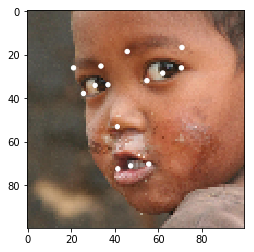

In [7]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

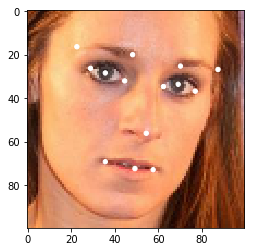

In [8]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [9]:
from keras.models import Sequential

from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential()

model.add(Conv2D(filters=32,  kernel_size=(3,3), padding='valid', activation='elu', input_shape=(100,100,3)))

model.add(Conv2D(24,5,5, subsample=(2,2), border_mode='valid',  activation="elu"))
model.add(BatchNormalization())

model.add(Conv2D(36,5,5, subsample=(2,2), activation="elu"))
model.add(BatchNormalization())

model.add(Conv2D(48,5,5, subsample=(2,2),activation="elu"))
model.add(BatchNormalization())

model.add(Conv2D(64,3,3, activation="elu"))
model.add(BatchNormalization())

model.add(Conv2D(64,3,3,activation="elu"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(50, activation='elu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(28))


# Define here your model

C:\Users\Kiko-PC\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Kiko-PC\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="valid", strides=(2, 2), activation="elu")`
  from ipykernel import kernelapp as app
C:\Users\Kiko-PC\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="elu")`
C:\Users\Kiko-PC\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activa

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [21]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback 
model.compile(loss='mse', optimizer='adam')

checkpoint = ModelCheckpoint('checkpoints/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=False,
                                 mode='auto')

history_object = model.fit(aug_imgs_train, 
          aug_points_train, 
          batch_size=256, 
          shuffle=True, 
          epochs=100, 
          validation_data=(imgs_val, points_val),
          callbacks=[checkpoint])


# Choose optimizer, compile model and run training

Train on 10800 samples, validate on 600 samples
Epoch 1/100
10800/10800 [==============================] - 6s 565us/step - loss: 0.0225 - val_loss: 0.0183
Epoch 2/100
10800/10800 [==============================] - 5s 455us/step - loss: 0.0184 - val_loss: 0.0174
Epoch 3/100
10800/10800 [==============================] - 5s 454us/step - loss: 0.0177 - val_loss: 0.0137
Epoch 4/100
10800/10800 [==============================] - 5s 454us/step - loss: 0.0170 - val_loss: 0.0190
Epoch 5/100
10800/10800 [==============================] - 5s 463us/step - loss: 0.0166 - val_loss: 0.0175
Epoch 6/100
10800/10800 [==============================] - 5s 458us/step - loss: 0.0162 - val_loss: 0.0180
Epoch 7/100
10800/10800 [==============================] - 5s 456us/step - loss: 0.0158 - val_loss: 0.0160
Epoch 8/100
10800/10800 [==============================] - 5s 457us/step - loss: 0.0155 - val_loss: 0.0218
Epoch 9/100
10800/10800 [==============================] - 5s 454us/step - loss: 0.0151 - val_lo

10800/10800 [==============================] - 5s 467us/step - loss: 0.0020 - val_loss: 0.0201
Epoch 77/100
10800/10800 [==============================] - 5s 461us/step - loss: 0.0020 - val_loss: 0.0198
Epoch 78/100
10800/10800 [==============================] - 5s 473us/step - loss: 0.0020 - val_loss: 0.0189
Epoch 79/100
10800/10800 [==============================] - 5s 458us/step - loss: 0.0020 - val_loss: 0.0205
Epoch 80/100
10800/10800 [==============================] - 5s 455us/step - loss: 0.0020 - val_loss: 0.0216
Epoch 81/100
10800/10800 [==============================] - 5s 457us/step - loss: 0.0020 - val_loss: 0.0199
Epoch 82/100
10800/10800 [==============================] - 5s 457us/step - loss: 0.0020 - val_loss: 0.0193
Epoch 83/100
10800/10800 [==============================] - 5s 460us/step - loss: 0.0020 - val_loss: 0.0208
Epoch 84/100
10800/10800 [==============================] - 5s 463us/step - loss: 0.0020 - val_loss: 0.0209
Epoch 85/100
10800/10800 [===============

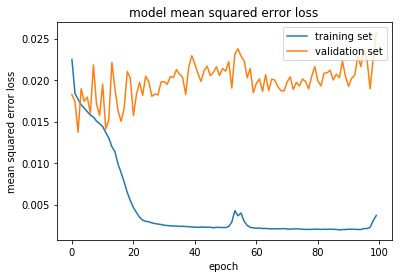

In [22]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

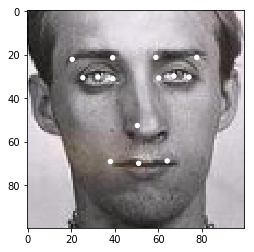

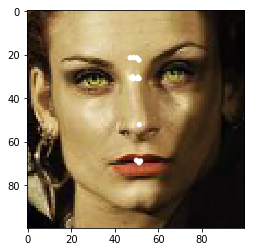

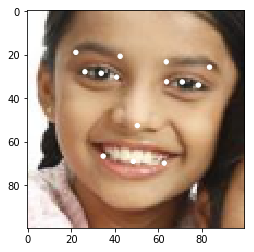

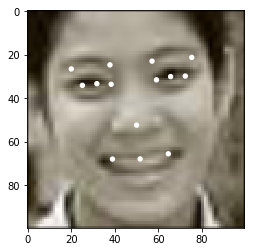

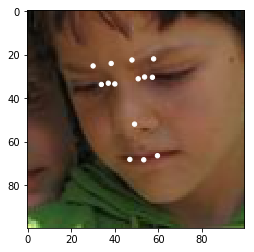

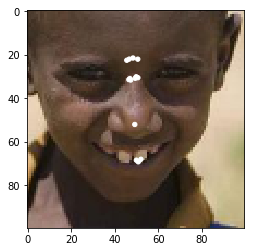

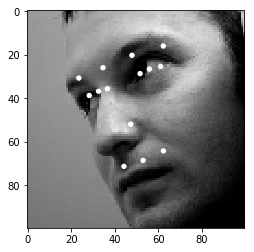

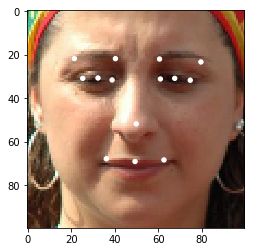

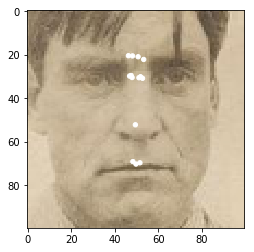

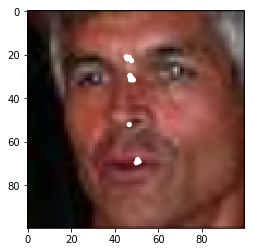

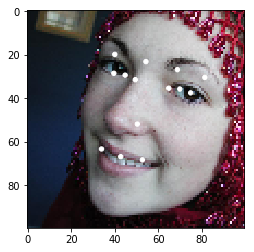

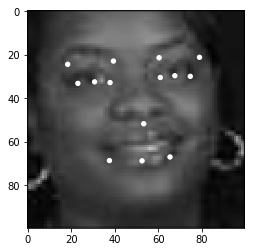

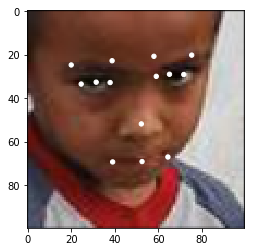

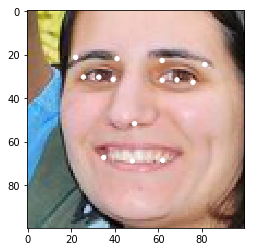

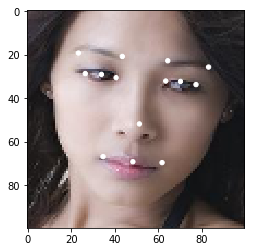

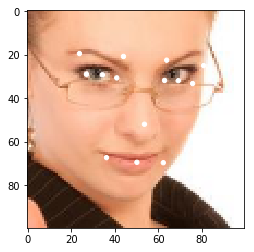

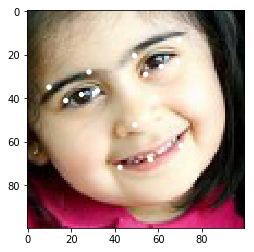

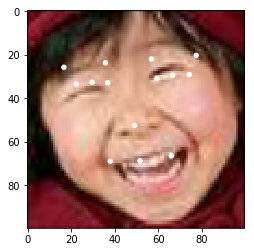

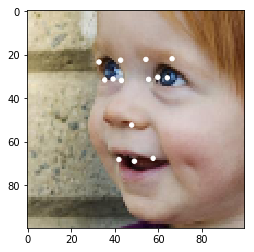

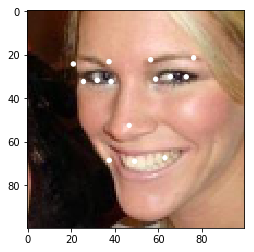

In [59]:
from random import randint


for i in range (0, 20):
    rand = randint(0,600)
    img = np.array([imgs_val[rand]])
    img_points = np.array([points_val[rand]])
    pred_points = model.predict(img)[0]
    visualize_points(img[0], pred_points)

